# Working with seismic and interpreted horizons

In [1]:
import pathlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")

In [2]:
from segysak.segy import (
    segy_loader,
    get_segy_texthead,
    segy_header_scan,
    segy_header_scrape,
    well_known_byte_locs,
)

In [3]:
segy_file = pathlib.Path("data/volve10r12-full-twt-sub3d.sgy")
cube = segy_loader(segy_file.absolute(), **well_known_byte_locs("petrel_3d"))

  0%|                                                                                                                                                                        | 0.00/12.3k [00:00<?, ? traces/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12.3k/12.3k [00:00<00:00, 38.4k traces/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12.3k/12.3k [00:00<00:00, 38.3k traces/s]

Loading as 3D
Fast direction is TRACE_SEQUENCE_FILE


Converting SEGY:   0%|                                                                                                                                                       | 0.00/12.3k [00:00<?, ? traces/s]

Converting SEGY:   7%|██████████▎                                                                                                                                     | 884/12.3k [00:00<00:01, 8.84k traces/s]

Converting SEGY:  15%|████████████████████▉                                                                                                                         | 1.81k/12.3k [00:00<00:01, 9.11k traces/s]

Converting SEGY:  23%|████████████████████████████████▎                                                                                                             | 2.80k/12.3k [00:00<00:01, 9.46k traces/s]

Converting SEGY:  31%|███████████████████████████████████████████▌                                                                                                  | 3.78k/12.3k [00:00<00:00, 9.60k traces/s]

Converting SEGY:  39%|███████████████████████████████████████████████████████▏                                                                                      | 4.78k/12.3k [00:00<00:00, 9.74k traces/s]

Converting SEGY:  47%|██████████████████████████████████████████████████████████████████▎                                                                           | 5.76k/12.3k [00:00<00:00, 9.30k traces/s]

Converting SEGY:  55%|█████████████████████████████████████████████████████████████████████████████▉                                                                | 6.77k/12.3k [00:00<00:00, 9.55k traces/s]

Converting SEGY:  63%|█████████████████████████████████████████████████████████████████████████████████████████▌                                                    | 7.77k/12.3k [00:00<00:00, 9.70k traces/s]

Converting SEGY:  71%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 8.79k/12.3k [00:00<00:00, 9.83k traces/s]

Converting SEGY:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 9.79k/12.3k [00:01<00:00, 9.91k traces/s]

Converting SEGY:  88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 10.8k/12.3k [00:01<00:00, 9.95k traces/s]

Converting SEGY:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 11.8k/12.3k [00:01<00:00, 8.95k traces/s]

Converting SEGY: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12.3k/12.3k [00:01<00:00, 9.44k traces/s]

In [4]:
print("Loaded cube size: {}".format(cube.seis.humanbytes))

Loaded cube size: 40.05 MB


In [5]:
print("Is it two-way-time? {}".format(cube.seis.is_twt()))

Is it two-way-time? True


## Load horizon data

First we load the horizon data to a Pandas DataFrame and take a look at the first few lines:

In [6]:
hrz_file = pathlib.Path("data/hor_twt_hugin_fm_top.dat")
hrz = pd.read_csv(hrz_file, names=["cdp_x", "cdp_y", "twt"], sep="\s+")
hrz.head()

,cdp_x,cdp_y,twt
0,432186.713151,6.477029e+06,2776.275147
1,432189.737524,6.477041e+06,2779.657715
2,432192.761898,6.477053e+06,2780.465088
3,432195.786271,6.477066e+06,2780.949951
4,432198.810645,6.477078e+06,2781.769775


## Display horizon and seismic extents

We can build a plot to display the horizon in its entirety and overlay it with the extent of the seismic cube previously loaded.

First we use **segysak** built-in `calc_corner_points()` method to calculate the corner points of the loaded cube and copy them to a numpy array to be used for the plot:

In [7]:
cube.seis.calc_corner_points()
corners = np.array(cube.attrs["corner_points_xy"])

To display the horizon we need to grid the raw data first:

In [8]:
from scipy.interpolate import griddata

xi = np.linspace(hrz.cdp_x.min(), hrz.cdp_x.max(), 250)
yi = np.linspace(hrz.cdp_y.min(), hrz.cdp_y.max(), 2500)
X, Y = np.meshgrid(xi, yi)
Z = griddata((hrz.cdp_x, hrz.cdp_y), hrz.twt, (X, Y))

And this is the resulting plot with the extent of the loaded cube displayed as a thick red outline:

Text(0.5, 1.0, 'Top Hugin fm.')

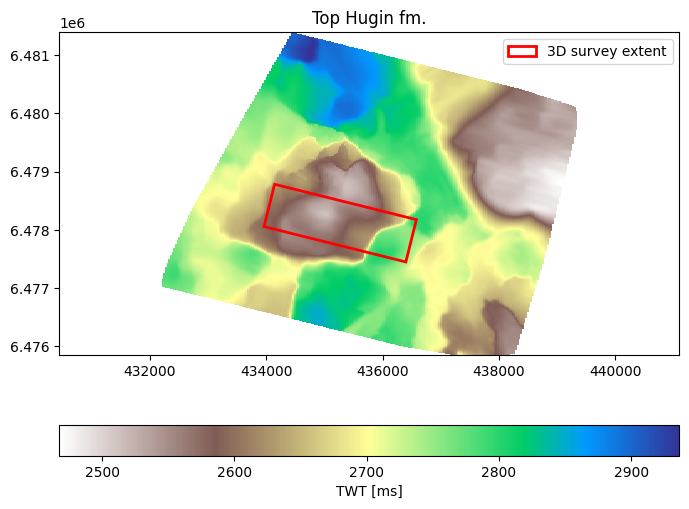

In [9]:
from matplotlib.patches import Polygon

survey_limits = Polygon(
    corners, fill=False, edgecolor="r", linewidth=2, label="3D survey extent"
)

f, ax = plt.subplots(figsize=(8, 6))
pp = ax.pcolormesh(X, Y, Z, cmap="terrain_r")
f.colorbar(pp, orientation="horizontal", label="TWT [ms]")
ax.add_patch(survey_limits)
ax.axis("equal")
ax.legend()
ax.set_title("Top Hugin fm.")

## Extracting amplitudes along the horizon

This is where the magic of segysak comes in. We use `surface_from_points` to map the loaded horizon imported in tabular format to each seismic bin. The input horizon in this case is defined in geographical coordinates but it would also have worked if it was defined in inlines and crosslines:

In [10]:
hrz_mapped = cube.seis.surface_from_points(hrz, "twt", right=("cdp_x", "cdp_y"))

And to extract seismic amplitudes along this horizon we use the magic of `xarray`:

In [11]:
amp = cube.data.interp(
    {"iline": hrz_mapped.iline, "xline": hrz_mapped.xline, "twt": hrz_mapped.twt}
)

For the next plot we use another attribute automatically calculated by **segysak** during loading to squeeze the colormap used when displaying amplitudes:

In [12]:
minamp, maxamp = cube.attrs["percentiles"][1], cube.attrs["percentiles"][-2]

...and we calculate the minimum and maximum X and Y coordinates using the `corners` array described above to set the figure extent and zoom in the area covered by the seismic cube:

In [13]:
xmin, xmax = corners[:, 0].min(), corners[:, 0].max()
ymin, ymax = corners[:, 1].min(), corners[:, 1].max()

We can plot `amp` now on top of the same twt grid we did above:

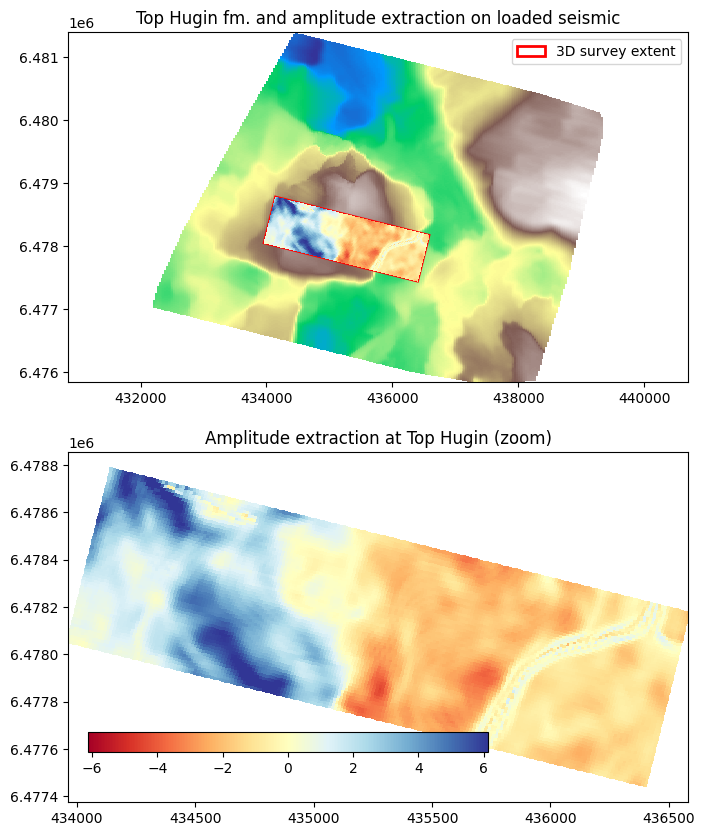

In [14]:
survey_limits = Polygon(
    corners, fill=False, edgecolor="r", linewidth=2, label="3D survey extent"
)

f, ax = plt.subplots(nrows=2, figsize=(8, 10))
ax[0].pcolormesh(X, Y, Z, cmap="terrain_r")
ax[0].add_patch(survey_limits)
for aa in ax:
    hh = aa.pcolormesh(
        amp.cdp_x, amp.cdp_y, amp.data, cmap="RdYlBu", vmin=minamp, vmax=maxamp
    )
    aa.axis("equal")
ax[0].legend()
ax[1].set_xlim(xmin, xmax)
ax[1].set_ylim(ymin, ymax)
ax[0].set_title("Top Hugin fm. and amplitude extraction on loaded seismic")
ax[1].set_title("Amplitude extraction at Top Hugin (zoom)")
cax = f.add_axes([0.15, 0.16, 0.5, 0.02])
f.colorbar(hh, cax=cax, orientation="horizontal")

Another classic display is to superimpose the structure contours to the amplitudes. This is much faster and easier using survey coordinates (inlines and crosslines):

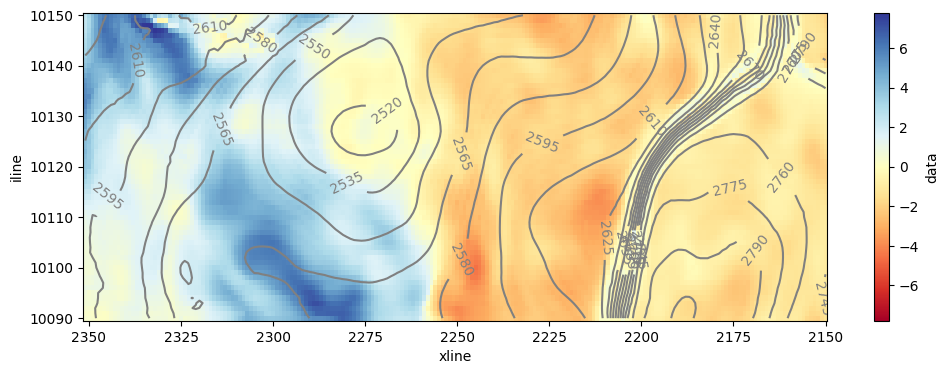

In [15]:
f, ax = plt.subplots(figsize=(12, 4))
amp.plot(cmap="RdYlBu")
cs = plt.contour(amp.xline, amp.iline, hrz_mapped.twt, levels=20, colors="grey")
plt.clabel(cs, fontsize=10, fmt="%.0f")
ax.invert_xaxis()

## Display horizon in section view

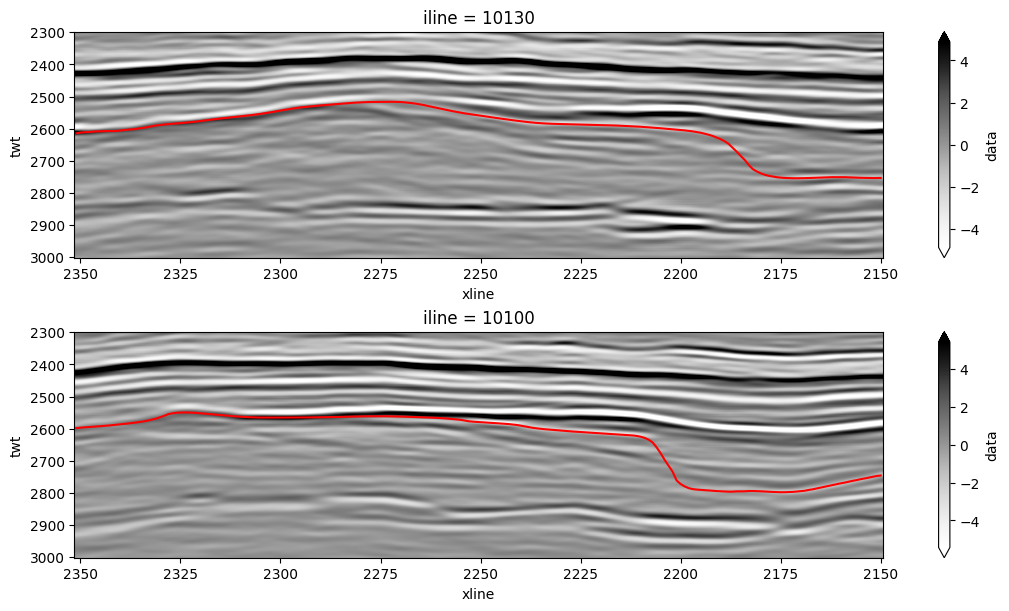

In [16]:
opt = dict(
    x="xline",
    y="twt",
    add_colorbar=True,
    interpolation="spline16",
    robust=True,
    yincrease=False,
    cmap="Greys",
)

inl_sel = [10130, 10100]

f, ax = plt.subplots(nrows=2, figsize=(10, 6), sharey=True, constrained_layout=True)
for i, val in enumerate(inl_sel):
    cube.data.sel(iline=val, twt=slice(2300, 3000)).plot.imshow(ax=ax[i], **opt)
    x, t = hrz_mapped.sel(iline=val).xline, hrz_mapped.sel(iline=val).twt
    ax[i].plot(x, t, color="r")
    ax[i].invert_xaxis()

We can also show an overlay of amplitudes and two-way-times along the same inlines:

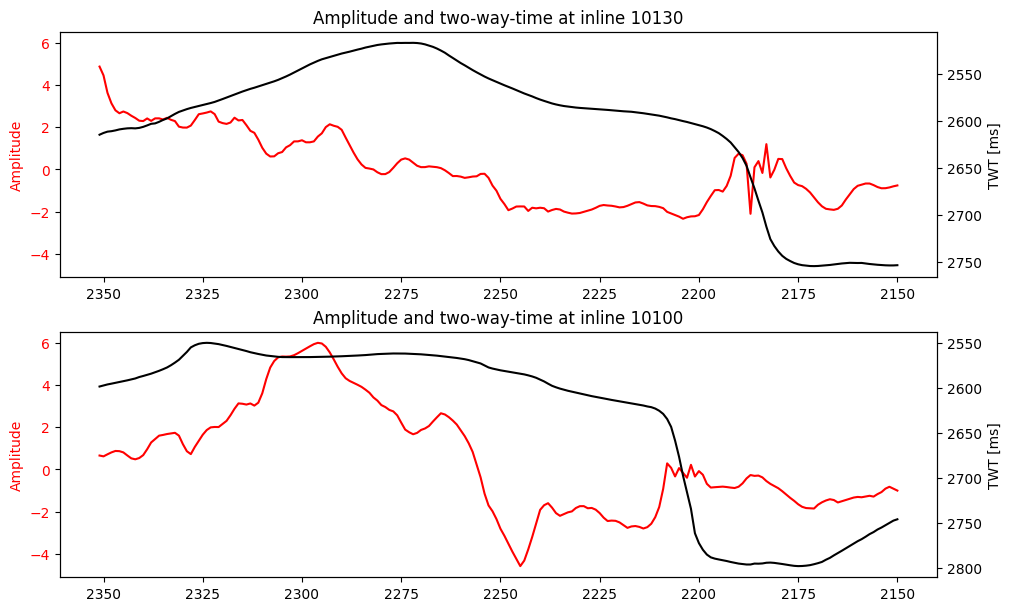

In [17]:
inl_sel = [10130, 10100]

f, ax = plt.subplots(nrows=2, figsize=(10, 6), sharey=True, constrained_layout=True)

for i, val in enumerate(inl_sel):
    axz = ax[i].twinx()
    x, t = amp.sel(iline=val).xline, amp.sel(iline=val).twt
    a = amp.sel(iline=val).data
    ax[i].plot(x, a, color="r")
    axz.plot(x, t, color="k")
    ax[i].invert_xaxis()
    axz.invert_yaxis()
    ax[i].set_ylabel("Amplitude", color="r")
    plt.setp(ax[i].yaxis.get_majorticklabels(), color="r")
    axz.set_ylabel("TWT [ms]")
    ax[i].set_title("Amplitude and two-way-time at inline {}".format(val))

## Horizon Sculpting and Windowed map Extraction

To create windows map extraction it is necessary to first mask the seisnc cube and then to collapse it along the chosen axis using a prefered method. In this case we are just going to calculate the mean amplitude in a 100ms window below our horizon.

In [18]:
mask_below = cube.where(cube.twt < hrz_mapped.twt + 100)
mask_above = cube.where(cube.twt > hrz_mapped.twt)
masks = [mask_above, mask_below]

Lets see what our masks look like

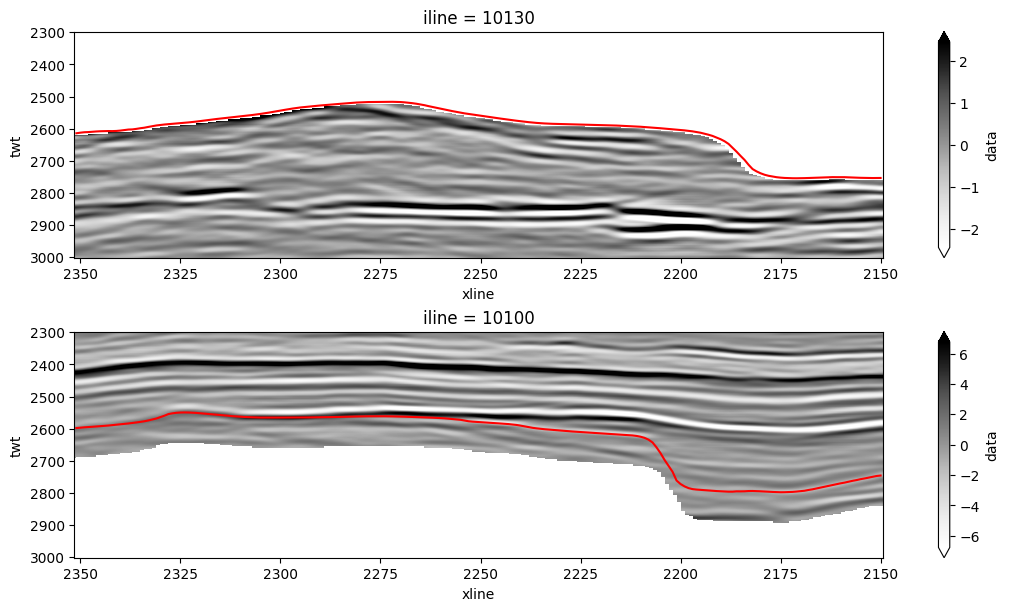

In [19]:
opt = dict(
    x="xline",
    y="twt",
    add_colorbar=True,
    interpolation="spline16",
    robust=True,
    yincrease=False,
    cmap="Greys",
)

inl_sel = [10130, 10100]

f, ax = plt.subplots(nrows=2, figsize=(10, 6), sharey=True, constrained_layout=True)
for i, val in enumerate(
    inl_sel,
):
    masks[i].data.sel(iline=val, twt=slice(2300, 3000)).plot.imshow(ax=ax[i], **opt)
    x, t = hrz_mapped.sel(iline=val).xline, hrz_mapped.sel(iline=val).twt
    ax[i].plot(x, t, color="r")
    ax[i].invert_xaxis()

And if we combine the masks.

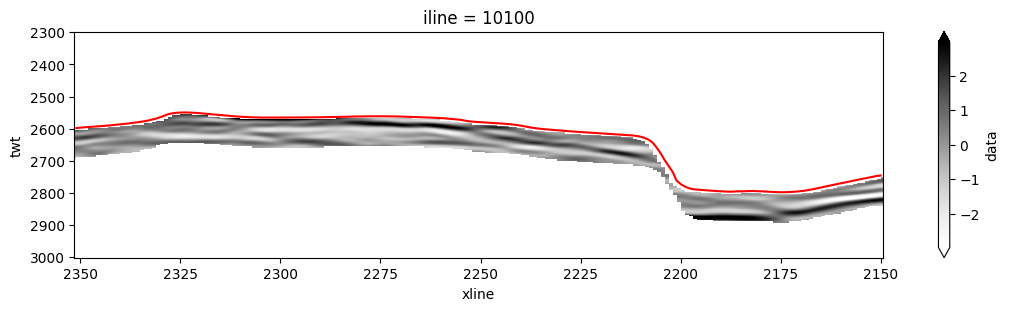

In [20]:
opt = dict(
    x="xline",
    y="twt",
    add_colorbar=True,
    interpolation="spline16",
    robust=True,
    yincrease=False,
    cmap="Greys",
)

inl_sel = [10130, 10100]

f, ax = plt.subplots(nrows=1, figsize=(10, 3), sharey=True, constrained_layout=True)

masked_data = 0.5 * (mask_below + mask_above)

masked_data.data.sel(iline=val, twt=slice(2300, 3000)).plot.imshow(ax=ax, **opt)
x, t = hrz_mapped.sel(iline=val).xline, hrz_mapped.sel(iline=val).twt
ax.plot(x, t, color="r")
ax.invert_xaxis()

To get the horizon window extraction for sum of amplitudes we now need to sum along the time axis. Or
we can use the `np.apply_along_axis` function to apply a custom function to our masked cube.

Text(0.5, 1.0, 'Sum of amplitudes Top Hugin 0 to +100ms')

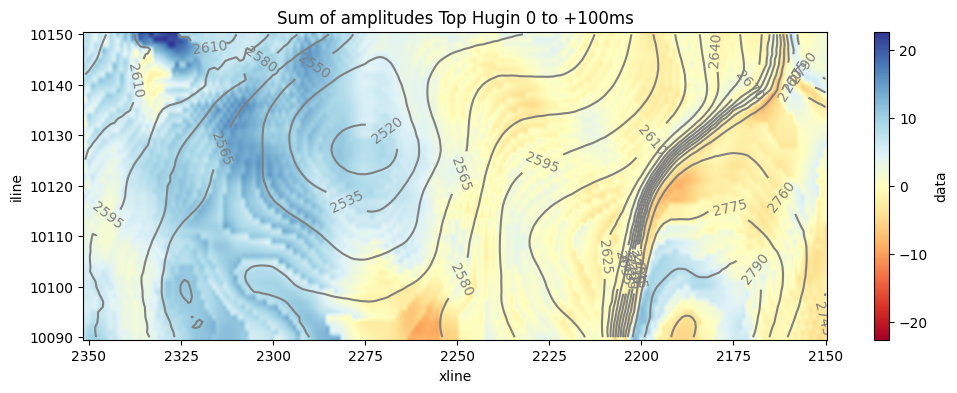

In [21]:
summed_amp = masked_data.sum(dim="twt")

f, ax = plt.subplots(figsize=(12, 4))
summed_amp.data.plot.imshow(
    cmap="RdYlBu",
    interpolation="spline16",
)
cs = plt.contour(amp.xline, amp.iline, hrz_mapped.twt, levels=20, colors="grey")
plt.clabel(cs, fontsize=10, fmt="%.0f")
ax.invert_xaxis()
ax.set_title("Sum of amplitudes Top Hugin 0 to +100ms")